In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

from tqdm import tqdm

from plot_evalue_distributions import plot_evalue_histograms, plot_evalue_kde
from complex_i_analysis import cluster_hits_with_strand, generate_subunit_data, classify_complex_types

import warnings
warnings.filterwarnings('ignore')

In [2]:
uniprot_length = pd.read_csv('/Users/akshayonly/Work/04-Complex-I/Data/02-Genomic-Records-and-Metadata/06-UniProt-InterPro/uniprot_reviewed_nuo_proteins_length.csv')

In [3]:
results = pd.read_csv("/Users/akshayonly/Work/04-Complex-I/Data/07-Figures/regenerate/results_unfil.csv")

In [4]:
# Set output directory
output_dir = "/Users/akshayonly/Work/04-Complex-I/Data/07-Figures/regenerate"

# Generate and save plots
# plot_evalue_histograms(results, output_dir)
# plot_evalue_kde(results, output_dir)

In [5]:
genomes_dataset = pd.read_csv('/Users/akshayonly/Work/04-Complex-I/Data/02-Genomic-Records-and-Metadata/02-Genome-Metadata/genomes_dataset.csv')
genomes_metadata = pd.read_csv('/Users/akshayonly/Work/04-Complex-I/Data/02-Genomic-Records-and-Metadata/02-Genome-Metadata/genomes_metadata.csv')
results = pd.merge(genomes_metadata.merge(results), genomes_dataset[['GenomeFile', 'Species', 'Organism']], on='GenomeFile')
# results.drop(columns=['GenomeFile'], inplace=True)

In [6]:
results.head(2)

,Accession,Replicon,GenomeFile,SequenceLength(Mb),ProteinAccession,evalue,BitScore,Bias,SequenceDesc,Subunit,Start,End,log10evalue,Species,Organism
0,AP024266.1,Chromosome,GCA_016755935.1_ASM1675593v1_genomic.fna,5.921363,AP024266.1_4313,2.000000e-256,851.8,16.0,# 4576494 # 4578395 # 1 # ID=1_4313;partial=00...,NuoL,4576494,4578395,-255.698970,Mycobacterium intracellulare,Bacteria
1,AP024266.1,Chromosome,GCA_016755935.1_ASM1675593v1_genomic.fna,5.921363,AP024266.1_4308,1.300000e-234,780.4,0.0,# 4571081 # 4573495 # 1 # ID=1_4308;partial=00...,NuoG,4571081,4573495,-233.886057,Mycobacterium intracellulare,Bacteria


In [7]:
results['Species'].nunique()

10460

In [8]:
hits_summaries = (
    results.groupby('Subunit')
    .agg(
        Species=('Species', 'nunique'),
        NoProteinHits=('ProteinAccession', 'nunique'),
        NoGenomes=('GenomeFile', 'nunique')
    )
    .assign(AvgHits=lambda df: df['NoProteinHits'] / df['NoGenomes'])
    .reset_index()
    .sort_values('AvgHits', ascending=False)
)


In [9]:
hits_summaries.head()

,Subunit,Species,NoProteinHits,NoGenomes,AvgHits
8,NuoG,9631,277362,40320,6.879018
10,NuoI,9884,231130,38772,5.961261
13,NuoL,9236,77059,37879,2.034346
7,NuoF,7981,63132,33122,1.906044
5,NuoD,6565,41155,23987,1.715721


In [10]:
combinations = {
    'Nuo14': ['NuoA', 'NuoB', 'NuoC', 'NuoD', 'NuoE', 'NuoF', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN'],
    'Nuo13': ['NuoA', 'NuoB', 'NuoCD', 'NuoE', 'NuoF', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN'],
    'Nuo12': ['NuoA', 'NuoBCD', 'NuoE', 'NuoF', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN'],
}

colors = ["#a5b1c2", "#f7b731", "#20bf6b", "#45aaf2", "#3867d6", "#a55eea", "#0fb9b1", '#4b6584']
labels = ['Nuo-Partial', 'Nuo13', 'Nuo14', 'Nuo14-EFG', 'Nuo13-EFG', 'Nuo14-EF', 'Nuo12', 'Existing Annotation']

complex_colors = dict(zip(labels, colors))

In [11]:
# Ensure unique subunits and sorted order
subunits = sorted(results['Subunit'].dropna().unique())

# Remove duplicate rows
results = results.drop_duplicates()

# Apply clustering in a more efficient manner
results = results.groupby('Accession', group_keys=False).apply(cluster_hits_with_strand, intergenic_distance=250)
results.reset_index(drop=True, inplace=True)

# Generate count and boolean tables
nuo_count, nuo_bool = generate_subunit_data(results, subunits)

# Remove duplicate rows in boolean table
nuo_bool.drop_duplicates(inplace=True)

# Classify complex types
nuo_bool = classify_complex_types(nuo_bool, combinations, subunits)

# Merge species and accession information while preserving unique records
nuo_bool = nuo_bool.merge(results[['Species', 'Accession']].drop_duplicates(), on="Accession", how="left")

In [12]:
nuo_bool.head(1)

,Accession,Cluster,Strand,NuoA,NuoB,NuoBCD,NuoC,NuoCD,NuoD,NuoE,...,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation,Species
0,AAAC01000001.1,0,-1,True,True,False,True,False,True,False,...,False,True,True,True,True,True,True,True,Nuo-Partial,Bacillus anthracis


In [13]:
results['Length'] = np.int16(round(abs(results['Start'] - results['End'])/ 3))

In [14]:
uniprot_maxlen_dict = uniprot_length.set_index('Subunit')['MaxLength'].to_dict()

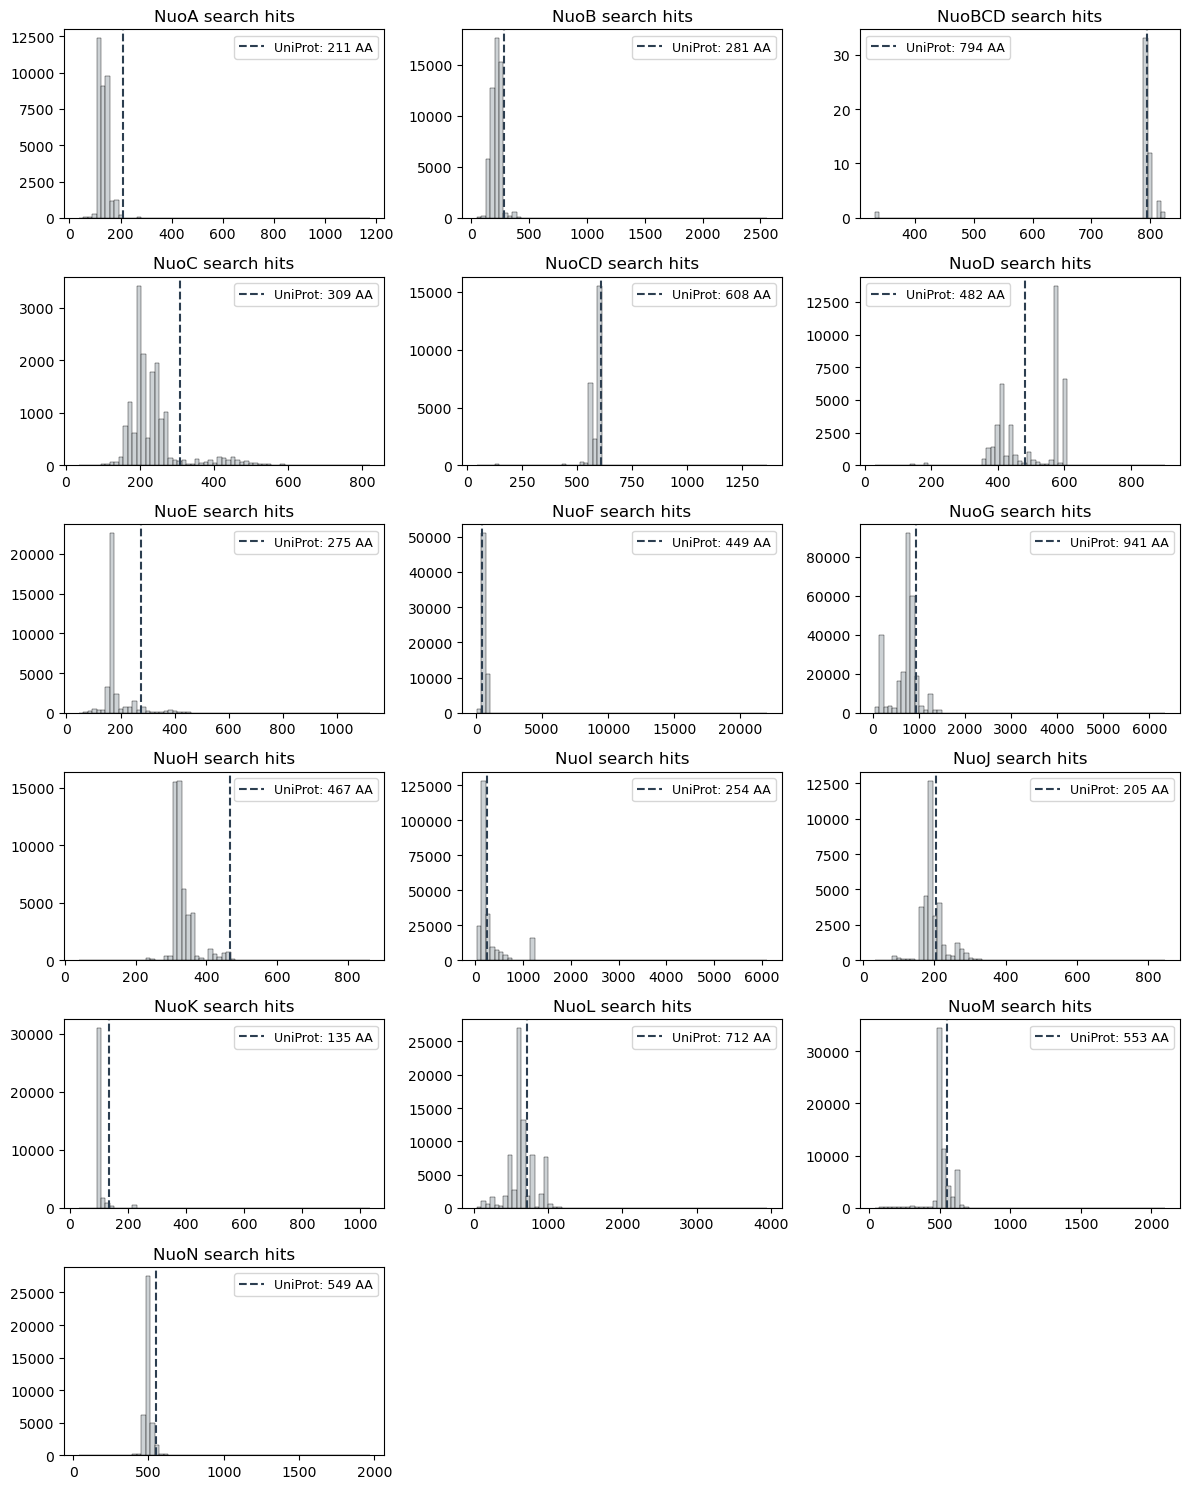

In [15]:
# Create figure and subplots (6 rows, 3 columns)
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(12, 15))
axes = axes.flatten()  # Flatten for easy iteration

# Iterate through subunits and plot in subplots
for i, subunit in enumerate(subunits):
    ax = axes[i]
    
    # Filter results for the subunit
    subunit_results = results[results['Subunit'] == subunit]

    # Plot histogram with KDE
    sns.histplot(data=subunit_results, x="Length", bins=65, color="#bdc3c7", kde=False, ax=ax)

    # Add vertical dashed line if UniProt MaxLength exists
    if (maxlength := uniprot_maxlen_dict.get(subunit)):  
        ax.axvline(x=maxlength, color="#2c3e50", linestyle="dashed", linewidth=1.5,
                   label=f'UniProt: {maxlength} AA')

    # Titles and aesthetics
    ax.set_title(f"{subunit} search hits", fontsize=12)
    ax.legend(fontsize=9)
    ax.set_xlabel("")  # Remove x-labels for compactness
    ax.set_ylabel("")  # Remove y-labels for compactness

# Hide the last two empty subplots
for j in range(len(subunits), len(axes)):
    axes[j].set_visible(False)  # Hides the unused subplots

# Adjust layout
plt.tight_layout()  # Ensures subplots don't overlap
plt.savefig('/Users/akshayonly/Work/04-Complex-I/Data/07-Figures/regenerate/hits_length_dist.pdf', format='pdf', dpi=500)
plt.savefig('/Users/akshayonly/Work/04-Complex-I/Data/07-Figures/regenerate/hits_length_dist.png', dpi=500)
# Show plot
plt.show()


In [16]:
evalue_cutoff = {
    'NuoA': -20, 'NuoB': -58, 'NuoBCD': -200, 'NuoC': -27,
    'NuoCD': -110, 'NuoD': -100, 'NuoE': -41, 'NuoF': -74,
    'NuoG': -80, 'NuoH': -75, 'NuoI': -38, 'NuoJ': -30,
    'NuoK': -24, 'NuoL': -145, 'NuoM': -95, 'NuoN': -78
}

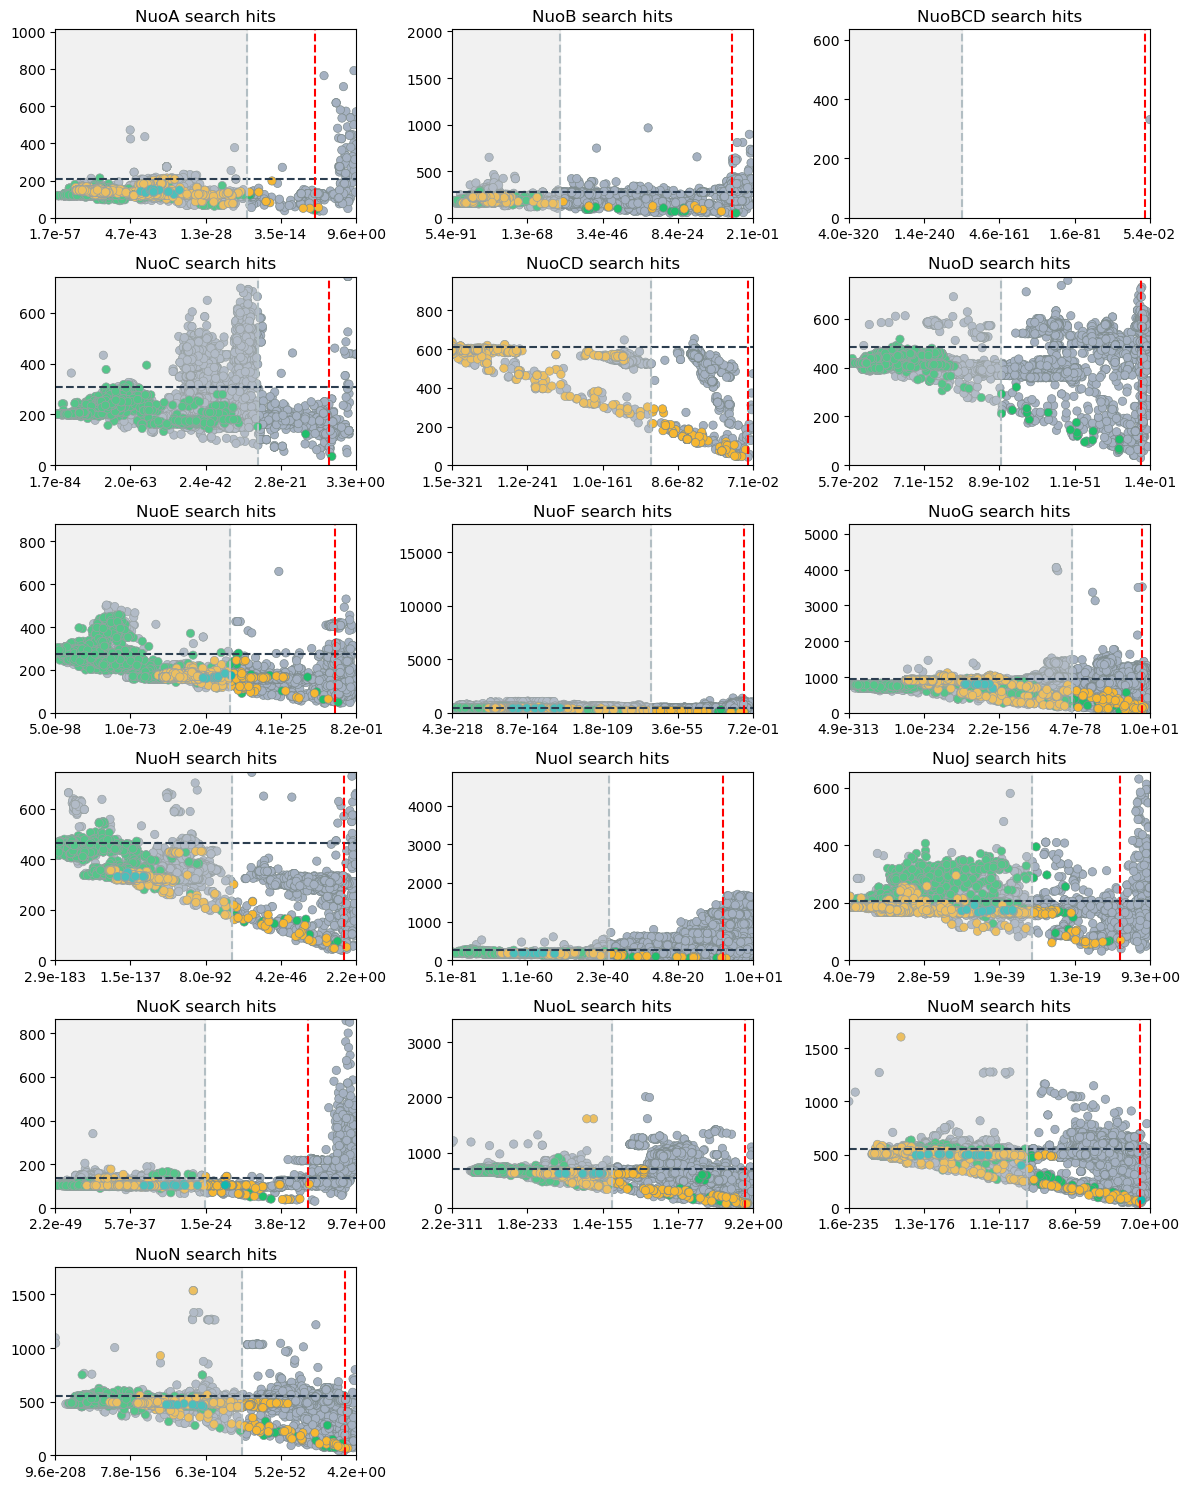

In [17]:
# Create figure and subplots (6 rows, 3 columns)
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(12, 15))
axes = axes.flatten()  # Flatten for easy iteration

# Define order of variations for correct marker layering
variation_order = ['Nuo12', 'Nuo13', 'Nuo14', 'Nuo-Partial']

# Loop through each subunit and create individual plots
for i, subunit in enumerate(subunits):
    ax = axes[i]
    
    # 1) Merge DataFrames (inner join keeps only matching rows)
    subunit_data = results.merge(
        nuo_bool[['Accession', 'Cluster', 'Variation']], 
        on=['Accession', 'Cluster'],
        how='inner'
    )

    # 2) Filter for the specific subunit
    subunit_data = subunit_data.loc[subunit_data['Subunit'] == subunit, 
                                    ['Accession', 'log10evalue', 'Length', 'Variation']]

    # 3) Handle infinite log10(e-value) by replacing them with (min finite value - 1)
    min_finite = subunit_data['log10evalue'][np.isfinite(subunit_data['log10evalue'])].min()
    subunit_data.loc[~np.isfinite(subunit_data['log10evalue']), 'log10evalue'] = min_finite - 1

    # 4) Convert 'Variation' to categorical type with specified order
    subunit_data['Variation'] = pd.Categorical(subunit_data['Variation'], categories=variation_order, ordered=True)

    # 5) Sort data by 'Variation' to control marker stacking order
    subunit_data = subunit_data.sort_values(by='Variation', ascending=False)  # Higher categories appear on top

    # 6) Scatter plot using seaborn
    sns.scatterplot(
        data=subunit_data,
        x="log10evalue",
        y="Length",
        hue="Variation",
        hue_order=variation_order,  # Ensure correct order in the legend
        palette=complex_colors,
        edgecolor='#7f8c8d',
        ax=ax
    )

    # 7) Determine dynamic range of log10 values in the data
    log_min = np.min(subunit_data['log10evalue'])
    log_max = np.max(subunit_data['log10evalue'])

    # Generate evenly spaced ticks in log scale
    log_ticks = np.linspace(log_min, log_max, num=5)
    original_ticks = 10**log_ticks  # Convert log10 values back to original scale

    # Set new x-axis ticks with original values
    ax.set_xticks(log_ticks)
    ax.set_xticklabels([f"{t:.1e}" for t in original_ticks])  # Format in scientific notation

    # Compute dynamic limit for y-axis
    uniprot_max = uniprot_maxlen_dict.get(subunit)  # Get UniProt max length
    if uniprot_max:
        observed_max = subunit_data['Length'].max()
        scale_factor = round(observed_max / uniprot_max) / 1.25
        limit = uniprot_max * scale_factor
    else:
        limit = subunit_data['Length'].max() * 1.1  # Fallback if UniProt length is missing

    ax.set_ylim(0, limit)

    # Add horizontal dashed line for UniProt max length
    if uniprot_max:
        ax.axhline(y=uniprot_max, color="#2c3e50", linestyle="dashed", linewidth=1.5)
        
    # Add vertical dashed line for log10(e-value) = 1e-7
    ax.axvline(x=np.log10(1e-7), color="red", linestyle="dashed", linewidth=1.5)
    
    # Add vertical dashed line for custom evalue threshold
    ax.axvline(x=evalue_cutoff.get(subunit, 0), linestyle='--', color='#b2bec3')
    
    # **Fix: Explicitly set x-limits before shading region**
    ax.set_xlim(log_min, log_max)

    # **Fix: Ensure `evalue_cutoff` exists & apply shaded region correctly**
    evalue_cutoff_value = evalue_cutoff.get(subunit, 0)  # Fallback to min if not found
    
    ax.axvspan(
        xmin=ax.get_xlim()[0],  # Extend shading from the leftmost limit
        xmax=evalue_cutoff_value,  # Use cutoff value, defaulting to 0 if not found
        color='#d3d3d3', 
        alpha=0.30, 
        zorder=1  # Ensure shaded region is in the background
    )
    
    # Titles and aesthetics
    ax.set_title(f"{subunit} search hits", fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("")

    # **Remove legend from subplots**
    ax.get_legend().remove()

# Hide any extra empty subplots (since we have only 16 subunits but 18 slots)
for j in range(len(subunits), len(axes)):
    axes[j].set_visible(False)

# Adjust layout for compact visualization
plt.tight_layout()

# Show plot
plt.show()


In [18]:
length_thresholds = {
    'NuoA': 245,
    'NuoB': 289,
    'NuoC': 311,
    'NuoE': 450,
    'NuoF': 540,
    'NuoG': 966,
    'NuoH': 549,
    'NuoI': 301,
    'NuoJ': 408,
    'NuoM': 1087,
    'NuoN': 664
}

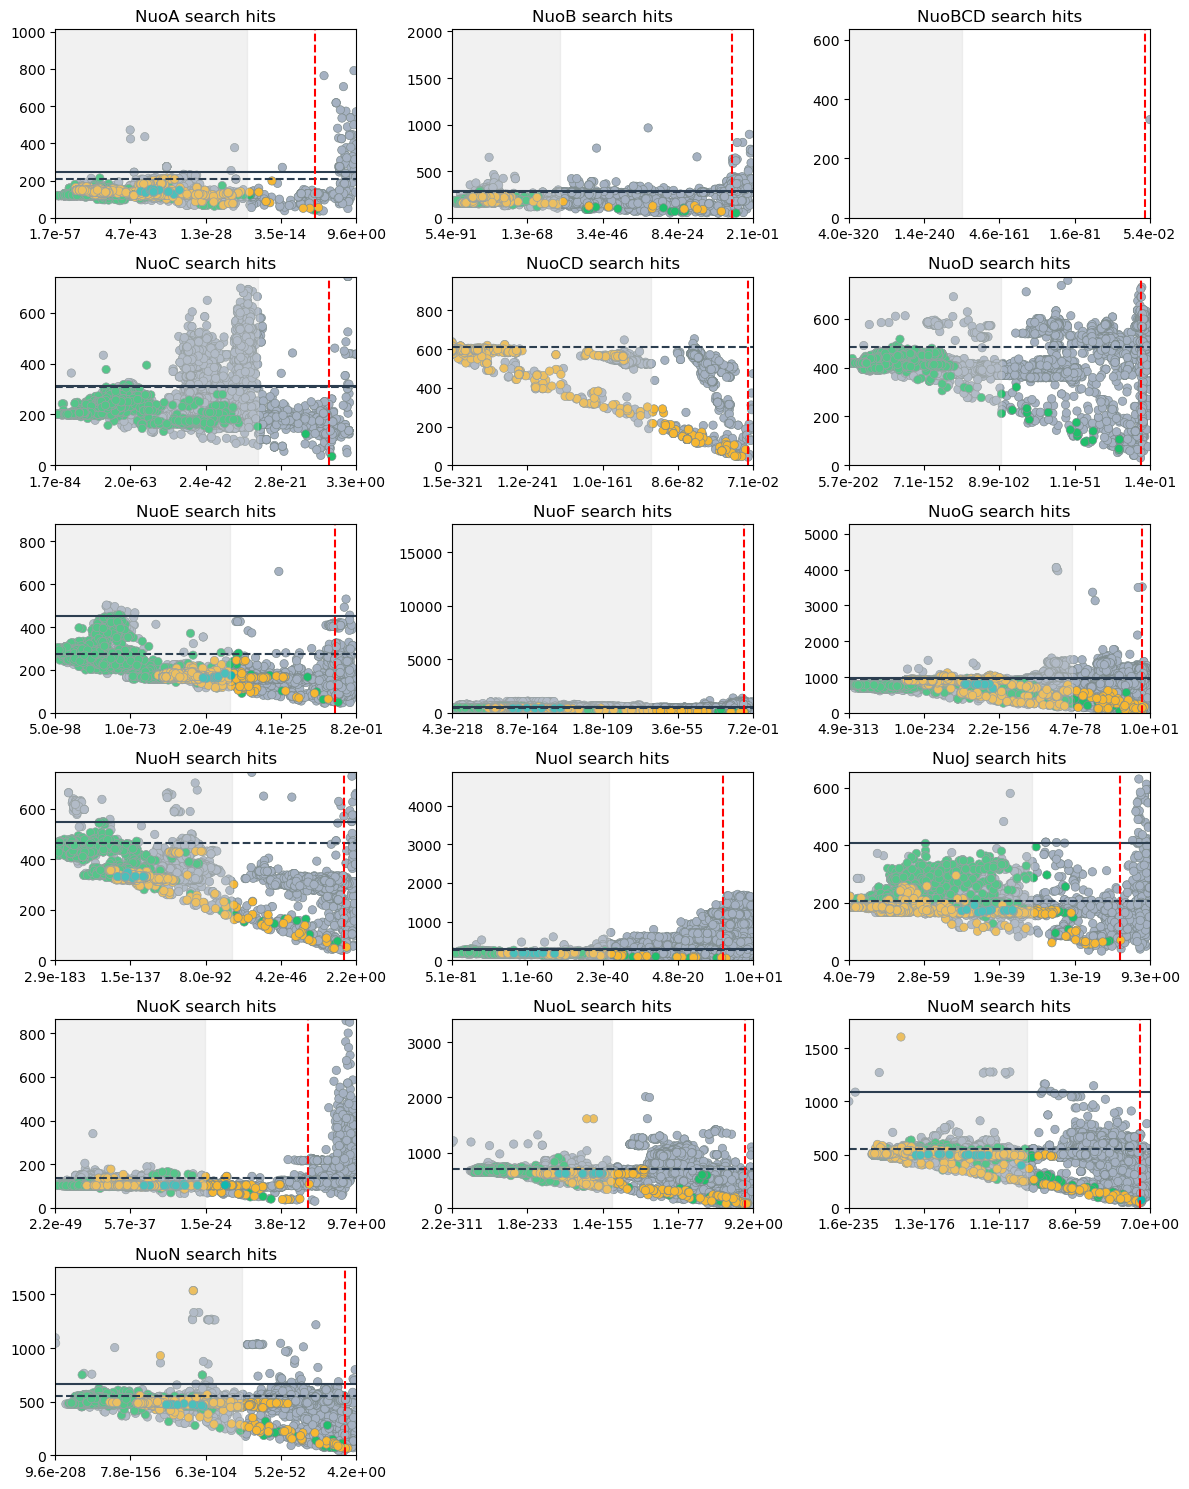

In [19]:
# Create figure and subplots (6 rows, 3 columns)
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(12, 15))
axes = axes.flatten()  # Flatten for easy iteration

# Define order of variations for correct marker layering
variation_order = ['Nuo12', 'Nuo13', 'Nuo14', 'Nuo-Partial']

# Loop through each subunit and create individual plots
for i, subunit in enumerate(subunits):
    ax = axes[i]
    
    # 1) Merge DataFrames (inner join keeps only matching rows)
    subunit_data = results.merge(
        nuo_bool[['Accession', 'Cluster', 'Variation']], 
        on=['Accession', 'Cluster'],
        how='inner'
    )

    # 2) Filter for the specific subunit
    subunit_data = subunit_data.loc[subunit_data['Subunit'] == subunit, 
                                    ['Accession', 'log10evalue', 'Length', 'Variation']]

    # 3) Handle infinite log10(e-value) by replacing them with (min finite value - 1)
    min_finite = subunit_data['log10evalue'][np.isfinite(subunit_data['log10evalue'])].min()
    subunit_data.loc[~np.isfinite(subunit_data['log10evalue']), 'log10evalue'] = min_finite - 1

    # 4) Convert 'Variation' to categorical type with specified order
    subunit_data['Variation'] = pd.Categorical(subunit_data['Variation'], categories=variation_order, ordered=True)

    # 5) Sort data by 'Variation' to control marker stacking order
    subunit_data = subunit_data.sort_values(by='Variation', ascending=False)  # Higher categories appear on top

    # 6) Scatter plot using seaborn
    sns.scatterplot(
        data=subunit_data,
        x="log10evalue",
        y="Length",
        hue="Variation",
        hue_order=variation_order,  # Ensure correct order in the legend
        palette=complex_colors,
        edgecolor='#7f8c8d',
        ax=ax
    )

    # 7) Determine dynamic range of log10 values in the data
    log_min = np.min(subunit_data['log10evalue'])
    log_max = np.max(subunit_data['log10evalue'])

    # Generate evenly spaced ticks in log scale
    log_ticks = np.linspace(log_min, log_max, num=5)
    original_ticks = 10**log_ticks  # Convert log10 values back to original scale

    # Set new x-axis ticks with original values
    ax.set_xticks(log_ticks)
    ax.set_xticklabels([f"{t:.1e}" for t in original_ticks])  # Format in scientific notation

    # Compute dynamic limit for y-axis
    uniprot_max = uniprot_maxlen_dict.get(subunit)  # Get UniProt max length
    if uniprot_max:
        observed_max = subunit_data['Length'].max()
        scale_factor = round(observed_max / uniprot_max) / 1.25
        limit = uniprot_max * scale_factor
    else:
        limit = subunit_data['Length'].max() * 1.1  # Fallback if UniProt length is missing

    ax.set_ylim(0, limit)

    # Add horizontal dashed line for UniProt max length
    if uniprot_max:
        ax.axhline(y=uniprot_max, color="#2c3e50", linestyle="dashed", linewidth=1.5)

    len_threshold = length_thresholds.get(subunit)
    
    if len_threshold:
        ax.axhline(y=len_threshold, color="#2c3e50", linestyle="solid", linewidth=1.5)
        
    # Add vertical dashed line for log10(e-value) = 1e-7
    ax.axvline(x=np.log10(1e-7), color="red", linestyle="dashed", linewidth=1.5)

    # **Fix: Explicitly set x-limits before shading region**
    ax.set_xlim(log_min, log_max)

    # **Fix: Ensure `evalue_cutoff` exists & apply shaded region correctly**
    evalue_cutoff_value = evalue_cutoff.get(subunit, log_min)  # Fallback to min if not found
    ax.axvspan(
        xmin=log_min, 
        xmax=evalue_cutoff_value, 
        color='#d3d3d3', 
        alpha=0.30, 
        zorder=1  # Ensure shaded region is in the background
    )
    
    # Titles and aesthetics
    ax.set_title(f"{subunit} search hits", fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("")

    # **Remove legend from subplots**
    ax.get_legend().remove()

# Hide any extra empty subplots (since we have only 16 subunits but 18 slots)
for j in range(len(subunits), len(axes)):
    axes[j].set_visible(False)

# Adjust layout for compact visualization
plt.tight_layout()

# Save plot
plt.savefig('/Users/akshayonly/Work/04-Complex-I/Data/07-Figures/regenerate/evalue_vs_length_subplots.pdf', 
            format='pdf', dpi=150)
plt.savefig('/Users/akshayonly/Work/04-Complex-I/Data/07-Figures/regenerate/evalue_vs_length_subplots.png', dpi=500)

# Show plot
plt.show()
